# 0. Ferromagnetic phase and paramagnetic phase classification

In this notebook, we attempt to classify the  ferromagnetic phase and the  paramagnetic phase. 

The Ising model is a mathematical model of ferromagnetism in statistical mechanics. The model consists of discrete variables that represent magnetic dipole moments of atomic "spins" that can be in one of two states (+1 or −1).

Below a certain temperature called the Curie temperature, $T_c$, most of the spins are parallel, which results in a uniform overall state characterised by $+1$ or $-1$. This phase is called the ferromagnetic phase. Above $T_c$, magnetic dipole moments of half of the atomic "spins" yield $+1$ while the other half yields $-1$. This phase is called the paramagnetic phase. 

This work aims to classify two different types of magnetic phases: a low-temperature ferromagnetic phase and a high-temperature paramagnetic phase. The details can be found in [Machine learning phases of matter](https://doi.org/10.1038/nphys4035). 

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)


Using TensorFlow v2.7.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# 1. Load the dataset

### Read raw data

The data is stored in 'Physics/ising_data.npz', containing 26000, gray-scale, 32 × 32 images of the magnetic phases. We will use 20000 images to train neural networks and the rest of them to evaluate the neural networks.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
f = np.load(join(data_path, 'Physics/ising_data.npz'))
n_train = 20000

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]
```
    
</p>
</details>

In [4]:
f = np.load(join(data_path, 'Physics/ising_data.npz'))
n_train = 20000

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

In [5]:
# define image size
IMG_HEIGHT = 32
IMG_WIDTH = 32
N_CHANNELS = 1
N_CLASSES = 2

### normalize data
x_train = (x_train + 1)/2.
x_test = (x_test + 1)/2.
x_train = x_train.reshape(-1, 32, 32, 1)
x_test = x_test.reshape(-1, 32, 32, 1)

Tc = 2.27
y_train, y_test = T_train > Tc, T_test > Tc

string_labels = ['paramagnetic','ferromagnetic']

# print
print("Number of training data: %d" % len(x_train))
print("Number of test data: %d" % len(x_test))
print("Image pixels: %s" % str(x_train[0, :, :, 0].shape))
print("Number of channels: %s" % str(x_train.shape[-1]))

Number of training data: 20000
Number of test data: 6000
Image pixels: (32, 32)
Number of channels: 1


/tmp/ipykernel_490577/1816722641.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  label = "%d: %s" % (y_train[idata], string_labels[y_train[idata]])


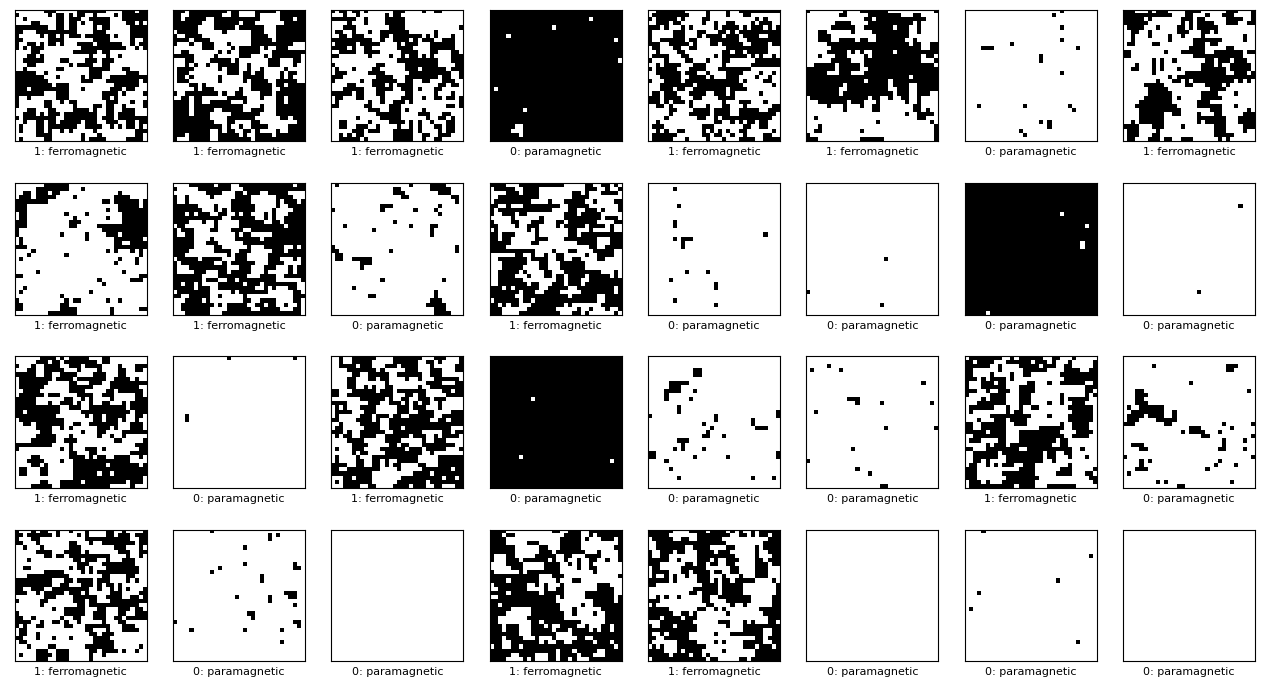

In [6]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(y_train), nrows * ncols)):
    label = "%d: %s" % (y_train[idata], string_labels[y_train[idata]])
    subplot_image(x_train[idata], label, nrows, ncols, iplot)
plt.show()

---

# 2. Build the network

The task is to build and train a CNN to solve this binary classification problem. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same',
                 input_shape=(32, 32, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# print summary
model.summary()
```
    
</p>
</details>

In [7]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same',
                 input_shape=(32, 32, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                        

2022-03-28 12:09:12.800778: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 12:09:13.374169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14773 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5


###  Compile the model

We can add the following metrics to see how the network performs for the two classes:

* `TruePositives`: number of right predictions for paramagnetic
* `FalsePositives`: number of wrong predictions for paramagnetic
* `TrueNegatives`: number of right predictions for ferromagnetic
* `FalseNegatives`: number of wrong predictions for ferromagnetic

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics= ['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])
```
    
</p>
</details>


In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics= ['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])

### Train the model

Using the suggested architecture, we can achieve an accuracy greater than 97% with 2 epochs. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)

training_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                             epochs=10, batch_size=64,callbacks=[stopper])

# print final values of metrics for validation data
print('Right for Paramagnetic: %d' % training_history.history['val_true_positives'][-1])
print('Wrong for Paramagnetic: %d' % training_history.history['val_false_positives'][-1])
print('Right for Ferromagnetic: %d' % training_history.history['val_true_negatives'][-1])
print('Wrong for Ferromagnetic: %d' % training_history.history['val_false_negatives'][-1])
```
    
</p>
</details>

In [9]:
stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)

training_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                             epochs=10, batch_size=64,callbacks=[stopper])

# print final values of metrics for validation data
print('Right for Paramagnetic: %d' % training_history.history['val_true_positives'][-1])
print('Wrong for Paramagnetic: %d' % training_history.history['val_false_positives'][-1])
print('Right for Ferromagnetic: %d' % training_history.history['val_true_negatives'][-1])
print('Wrong for Ferromagnetic: %d' % training_history.history['val_false_negatives'][-1])

Epoch 1/10


2022-03-28 12:09:14.988685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-28 12:09:15.442493: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 12:09:15.443103: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 12:09:15.443118: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-28 12:09:15.443633: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-28 12:09:15.443676: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


313/313 [==============================] - 5s 8ms/step - loss: 0.0632 - accuracy: 0.9761 - true_positives: 9709.0000 - false_positives: 223.0000 - true_negatives: 9812.0000 - false_negatives: 256.0000 - val_loss: 0.3847 - val_accuracy: 0.8422 - val_true_positives: 2088.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 2965.0000 - val_false_negatives: 947.0000
Epoch 2/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0474 - accuracy: 0.9807 - true_positives: 9759.0000 - false_positives: 181.0000 - true_negatives: 9854.0000 - false_negatives: 206.0000 - val_loss: 0.0491 - val_accuracy: 0.9798 - val_true_positives: 2950.0000 - val_false_positives: 36.0000 - val_true_negatives: 2929.0000 - val_false_negatives: 85.0000
Epoch 3/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0457 - accuracy: 0.9815 - true_positives: 9773.0000 - false_positives: 177.0000 - true_negatives: 9858.0000 - false_negatives: 192.0000 - val_loss: 0.0401 - val_accuracy: 

---

# 3. Analyse results 

### Plot training history

For convenience, we define a function to plot a training history:

In [10]:
# a function to plot training history
def plot_history(training_history):
    # plot accuracy
    plt.figure(dpi=100, figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history[acc_str], label='Accuracy on training data')
    plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
    plt.legend()
    plt.title("Accuracy")

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Loss on training data')
    plt.plot(training_history.history['val_loss'], label='Loss on test data')
    plt.legend()
    plt.title("Loss")
    plt.show()

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot training history
plot_history(training_history)
```
    
</p>
</details>

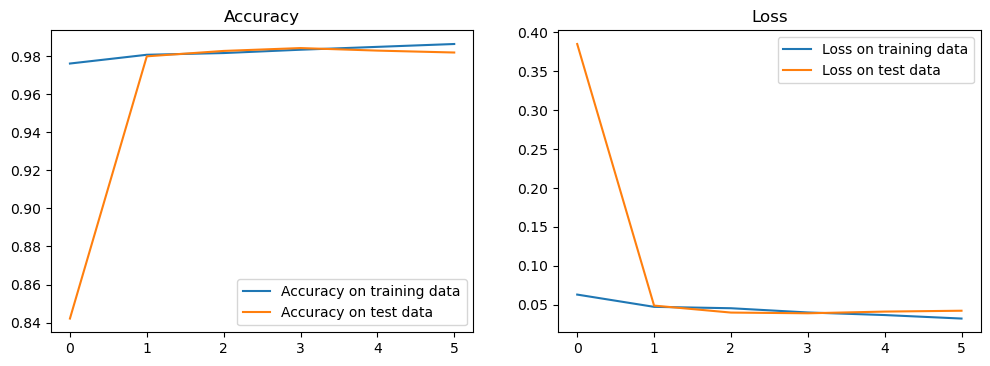

In [11]:
# plot training history
plot_history(training_history)

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Change the architeture and activation functions of neural networks to improve the accuracy